# Inverse Kinematics:  
### Homogeneous Transformation Matrix  and Jacobian Matrix by cross products  

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, pinv, norm

In [2]:
# 4x4 homogeneous transformation matrix
def H(L, TH):
    return np.array([[np.cos(TH), - np.sin(TH), 0, L],
                     [np.sin(TH),   np.cos(TH), 0, 0],
                     [         0,            0, 1, 0],
                     [         0,            0, 0, 1]])

# forward kinematics returns 3x(N+1) matrix: N-joints vectors and End-effector vector
def FK(L, TH):
    N = len(L)
    T = H(0, TH[0])
    V = np.zeros(3)
    for i in range(N-1):
        T = T @ H(L[i], TH[i+1])
        V = np.c_[V, T[:3, -1]]
    EE = T @ np.array([[L[-1], 0, 0, 1]]).T
    V = np.c_[V, EE[:3, -1]]
    return V

# plot function
def Plot(V):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    n = len(V[0])
    ax.axis('equal')
    ax.axis([-1, n, -1, n])
    ax.grid()
    ax.plot(V[0], V[1])
    ax.scatter(V[0], V[1])
    ax.plot(Target[0], Target[1], marker='x', ms=20, color='red')

## FK with Homogeneous transformation matrix

Target overwritten: [2.12132034 2.12132034 0.        ]


<IPython.core.display.Javascript object>


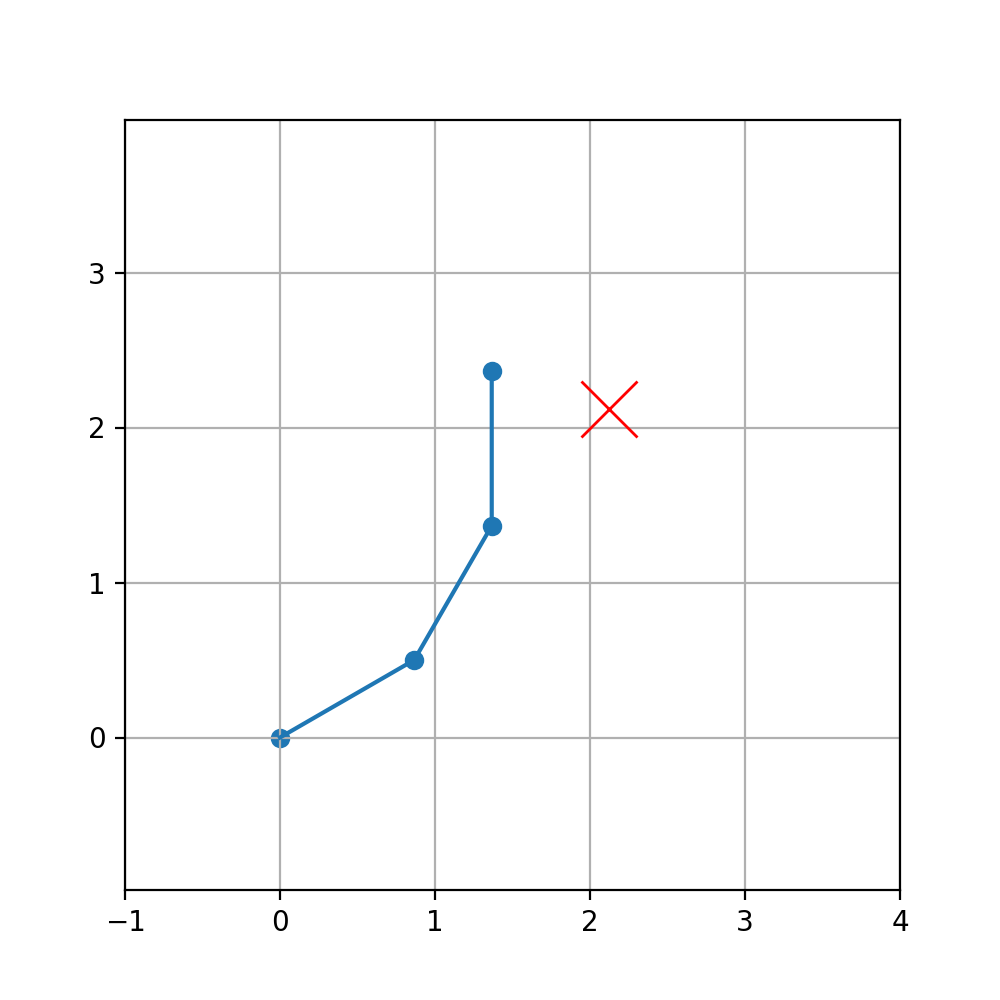

Target      : [2.12132034 2.12132034 0.        ]
End-Effector: [1.3660254 2.3660254 0.       ]


In [3]:
N = 3                        # the number of links
L = [1] * N                  # length of each link
TH = [np.pi / 2 / N] * N     # theta at each joint

Target = np.array([3, 3, 0]) # x, y, z coords
if norm(Target) > sum(L):
    Target = Target * sum(L) / norm(Target)
    print('Target overwritten:', Target)

V = FK(L, TH) # V: all-joints and End-Effector vectors
Plot(V)
print('Target      :', Target)
print('End-Effector:', V[:, -1])

## IK: 3xN Jacobian matrix by cross products

Error Norm  : 9.113358150615899e-05
Target      : [10 12  0]
End-Effector: [10.00008061 12.00004251  0.        ]
Loop: 97


<IPython.core.display.Javascript object>


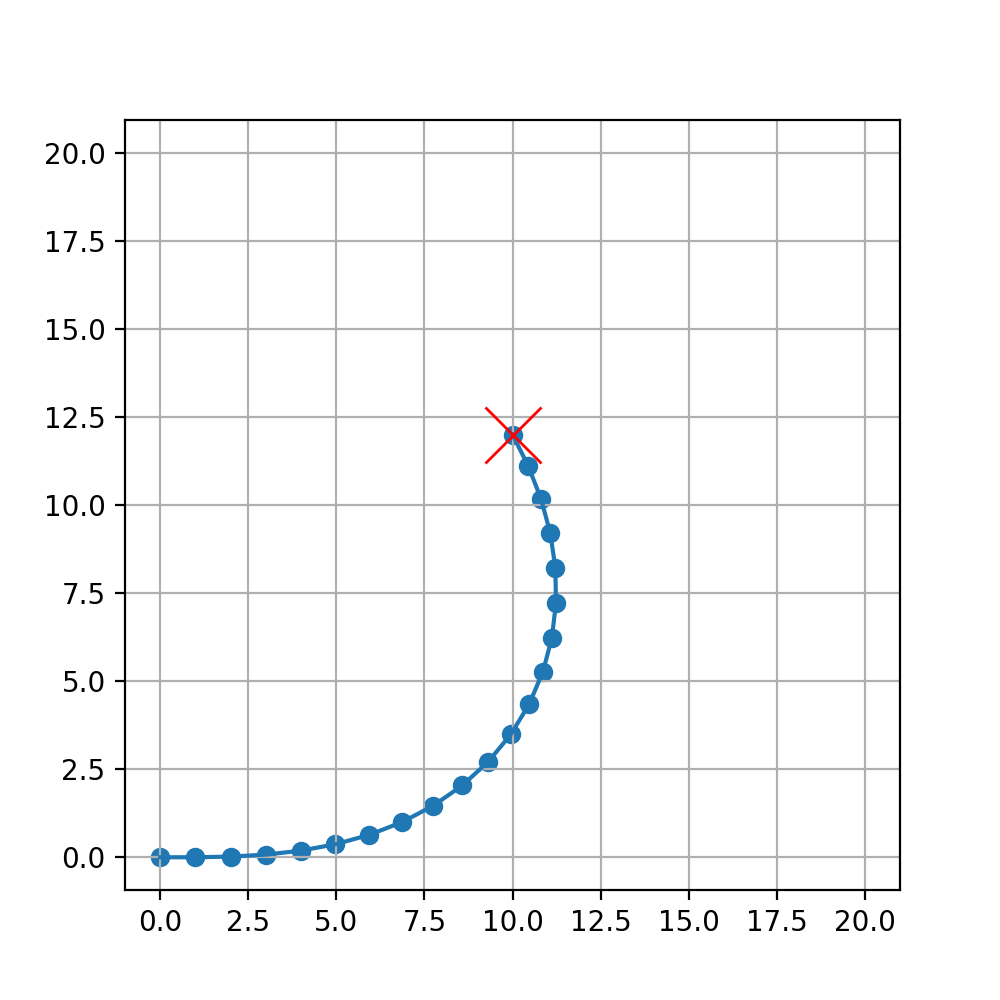

In [4]:
N = 20                        # the number of links
L = [1] * N                  # length of each link
TH = [np.pi / 2 / N] * N     # theta at each joint

Target = np.array([10, 12, 0]) # x, y, z
if norm(Target) > sum(L):
    Target = Target * sum(L) / norm(Target)
    print('Target overwritten')
    
def Jacobian(V):             # returns 3xN Jacobian matrix
    UV = np.array([0, 0, 1]) # z-axis unit vector
    J = []
    for i in range(N):
        # ith_J = UV x (End_effector_vector - ith_Joint_vector)
        J.append(np.cross(UV, V[:, -1] - V[:, i]))
    return np.array(J).T

scaler = 0.1
loop = 0

while True:
    V = FK(L, TH)
    J = Jacobian(V)
    Error = Target - V[:, -1]
    if norm(Error) < 1e-4:
        print('Error Norm  :', norm(Error))
        print('Target      :', Target)
        print('End-Effector:', V[:, -1])
        print('Loop:', loop)
        Plot(V)
        break
    dTheta = pinv(J) @ Error * scaler
    TH += dTheta
    loop += 1
    if loop > 1000:
        print('over 1000 loops')
        break

## IK Interactive mode: Arm follows Mouse

In [9]:
N = 3                        # the number of links
L = [1] * N                  # length of each link
TH = [np.pi / 2 / N] * N     # theta at each joint
scaler = 0.2

def motion(event):
    global TH
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    Target = np.array([mx, my, 0])  # target: mouse coords
    if norm(Target) > sum(L):       # overwrite the target coord if not reachable
        Target = Target * sum(L) / norm(Target)
    
    V = FK(L, TH)                   # V: Joints vectors from Forward Kinematiks
    Line.set_data(V[0], V[1])
    Dot.set_data(V[0], V[1])
    
    Error = Target - V[:, -1]       # error between Target-vector and current End-effector-vector
    J = Jacobian(V)                 # 3xN Jacobian Matrix
    Jpinv = pinv(J)                 # Pseudo-inverse Jacobian Matrix: JT·inv(J·JT)
    dTheta = Jpinv @ Error * scaler # to get delta thetas from Inverse Kinematics
    TH += dTheta                    # delta thetas for the next motion

    plt.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis('equal')
ax.axis([-1, N, -1, N])
ax.grid()

Line, = ax.plot([],[], linestyle='-', color='tab:blue')
Dot, = ax.plot([],[], marker='o', color='tab:blue')
Mouse, = ax.plot([],[], marker='x', ms=20, color='red')

plt.connect('motion_notify_event', motion)
plt.show()

<IPython.core.display.Javascript object>